In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from typing import Callable

In [ ]:
def to_points(x, N=None, d=None):
    """Accepts x as (N,d) array or flat (N*d,) vector."""
    x = np.asarray(x, dtype=float)
    if x.ndim == 2:
        return x
    if x.ndim == 1:
        assert N is not None and d is not None, "For flat x, provide N and d."
        return x.reshape(N, d)
    raise ValueError("x must be a flat vector or an (N,d) array.")


def plot_configuration_2d(points: np.ndarray, r_min=None, title=None):
    fig, ax = plt.subplots()

    ax.scatter(points[:, 0], points[:, 1])
    for i, (px, py) in enumerate(points):
        ax.text(px, py, str(i), ha="left", va="bottom")

    if r_min is not None:
        rad = 0.5 * float(r_min)
        for px, py in points:
            ax.add_patch(Circle((px, py), rad, fill=False))

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25)
    plt.show()

    return ax


def plot_configuration_3d(points: np.ndarray, r_min=None, title=None):
    N = points.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(points[:, 0], points[:, 1], points[:, 2])  # type: ignore

    for j in range(N):
        for k in range(j + 1, N):
            xs = [points[j, 0], points[k, 0]]
            ys = [points[j, 1], points[k, 1]]
            zs = [points[j, 2], points[k, 2]]
            ax.plot(xs, ys, zs, alpha=0.5)

    # if r_min is not None:

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.show()

    return ax

In [ ]:
def softplus(z):
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def unpack(x, N, d):
    return x.reshape(N, d)


def objective(
    x: np.ndarray,
    N: int,
    d: int,
    eps: float = 1.0,
    sigma: float = 1.0,
    r_min: float = 0.9,
    mu_sep: float = 10.0,
    lam_com: float = 10.0,
):
    P = unpack(x, N, d)
    J = 0.0
    G = np.zeros_like(P)

    # Center of mass penalty
    com = P.mean(axis=0)
    J += lam_com * (com @ com)
    G += (2.0 * lam_com / N) * com

    for i in range(N):
        for j in range(i + 1, N):
            rij_vec = P[i] - P[j]
            r = np.linalg.norm(rij_vec) + 1e-9

            # Lennard-Jones Energy
            sr = sigma / r
            sr6 = sr**6
            sr12 = sr6**2
            V = 4.0 * eps * (sr12 - sr6)
            J += V
            dV_dr = 24.0 * eps * (-2.0 * (sigma**12) / (r**13) + (sigma**6) / (r**7))

            # Sep penalty: softplus(r_min - r)^2
            u = r_min - r
            sp = softplus(u)
            J += mu_sep * (sp * sp)
            dsep_dr = mu_sep * (-2.0 * sp * sigmoid(u))

            grad_vec = (dV_dr + dsep_dr) * (rij_vec / r)
            G[i] += grad_vec
            G[j] -= grad_vec

    return J, G.reshape(-1)

In [36]:
def strong_wolfe_line_search(
    xk: np.ndarray,
    pk: np.ndarray,
    f: Callable,
    grad_f: Callable,
    c1=1e-3,
    c2=0.9,
    alpha_1=1.0,
    alpha_max=50.0,
    max_iter=100,
):
    def phi(alpha: float) -> float:
        return f(xk + alpha * pk)

    def dphi(alpha: float) -> float:
        return grad_f(xk + alpha * pk).dot(pk)

    phi0, dphi0 = phi(0.0), dphi(0.0)
    # assert dphi(0.0) < 0

    def zoom(alpha_low: float, alpha_high: float) -> float:
        a_j = (alpha_low + alpha_high / 2.0)
        for _ in range(max_iter):
            phi_aj = phi(a_j)
            phi_low = phi(alpha_low)
            if (phi_aj > phi0 + c1 * a_j * dphi0) or (phi_aj >= phi_low):
                alpha_high = a_j
            else:
                dphi_aj = dphi(a_j)
                if abs(dphi_aj) <= c2 * abs(dphi0):
                    return a_j
                if dphi_aj * (alpha_high - alpha_low) >= 0:
                    alpha_high = alpha_low
                alpha_low = a_j
            a_j = (alpha_low + alpha_high) / 2.0
        return a_j

    alpha_prev = 0.0
    alpha_curr = alpha_1
    phi_prev = phi0

    for i in range(max_iter):
        phi_a = phi(alpha_curr)
        if (phi_a > phi0 + c1 * alpha_curr * dphi0) or (phi_a >= phi_prev and i > 0):
            return zoom(alpha_prev, alpha_curr)
        dphi_a = dphi(alpha_curr)
        if abs(dphi_a) <= c2 * abs(dphi0):
            return alpha_curr
        if dphi_a >= 0.0:
            return zoom(alpha_prev, alpha_curr)

        alpha_prev, phi_prev = alpha_curr, phi_a
        alpha_curr = min(2.0 * alpha_curr, alpha_max)

    return alpha_curr


def quasi_newton_line_search(
    x0: np.ndarray,
    H0: np.ndarray,
    f: Callable,
    grad_f: Callable,
    c1=1e-3,
    c2=0.9,
    tol=1e-6,
    max_iter=1000,
):
    xk = np.array(x0, dtype=float)
    n = xk.size
    Hk = np.array(H0, dtype=float)
    I = np.eye(n)  # noqa: E741
    f_hist = [f(xk)]

    for _ in range(max_iter):
        gk = grad_f(xk)
        if np.linalg.norm(gk) < tol:
            break

        # 1) Compute search direction
        pk = -Hk.dot(gk)

        # 2) x_k <- x_k + alpha p_k
        alpha = strong_wolfe_line_search(
            xk=xk,
            pk=pk,
            f=f,
            grad_f=grad_f,
            c1=c1,
            c2=c2,
        )
        x_next = xk + alpha * pk
        g_next = grad_f(x_next)

        # 3) Compute s_k and y_k
        s = x_next - xk
        y = g_next - gk
        ys = y.dot(s)

        # 4) BFGS update (with safeguard)
        if ys > 1e-12:
            rho = 1.0 / ys
            V = I - rho * np.outer(s, y)
            Hk = V.dot(Hk).dot(V.T) + rho * np.outer(s, s)
        else:
            Hk = I.copy()

        xk = x_next
        f_hist.append(f(xk))

    return xk, np.array(f_hist, dtype=float)

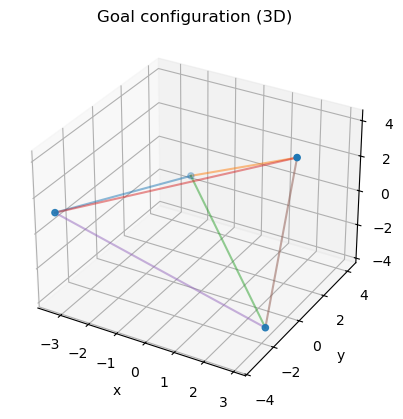

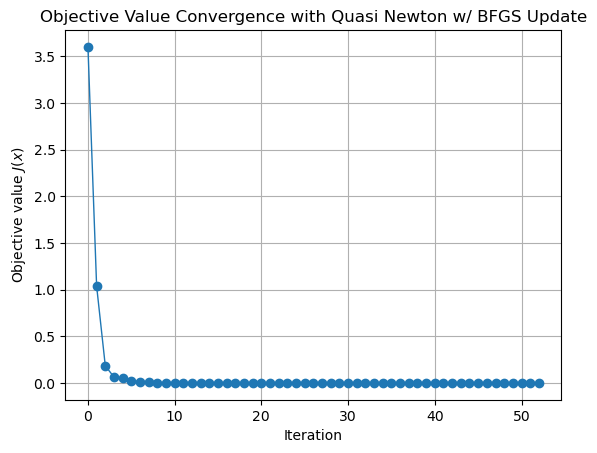

In [46]:
N = 4
d = 3
x0 = np.random.uniform(-1.5, 1.5, size=(N * d,))
H0 = np.eye(N * d)


def f(x):
    J, _ = objective(x, N, d)
    return J


def grad_f(x):
    _, g = objective(x, N, d)
    return g


x_star, f_hist = quasi_newton_line_search(x0=x0, H0=H0, f=f, grad_f=grad_f)
points = to_points(x_star, N=N, d=d)
plot_configuration_3d(points, r_min=1.0, title="Goal configuration (3D)")

plt.figure()
plt.plot(range(len(f_hist)), f_hist, marker="o", linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Objective value $J(x)$")
plt.title("Objective Value Convergence with Quasi Newton w/ BFGS Update")
plt.grid(True)
plt.show()